In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
import bootstrap_confidence_binary
bootstrap_confidence_binary.bootstrap_binary_hardtrials(n_boot_iter = 1000)

0
1
2
3
4
5
6


In [2]:
import bootstrap_confidence_binary
bootstrap_confidence_binary.bootstrap_binary_hardtrials_include_checker(n_boot_iter = 1000, \
                                                                        correct_only=True)

0
1
2
3
4
5
6


In [5]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [6]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [9]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_binary_hardtrials_include_checker_bootstrap_correctonly.npy')
b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']

Text(0.5, 0.98, 'Centermost trials, mean +/- SEM across subjects')

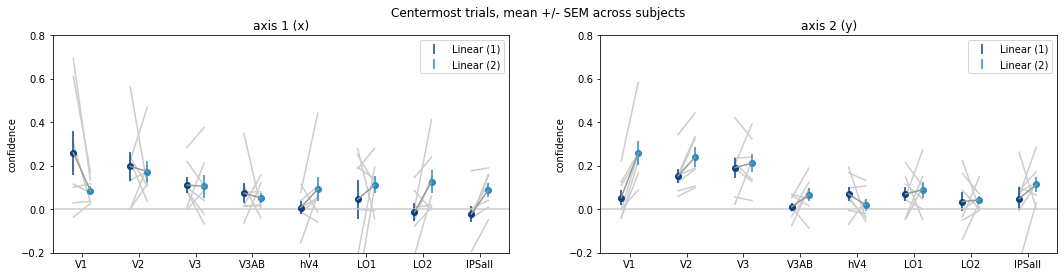

In [8]:
vals = np.mean(signedconf_hardtrials_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))


for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    # non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

    for ti in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        plt.plot(x_ticks, meanvals[:,ti,ii], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti,ii], \
                         semvals[:,ti,ii], \
                         xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,:,ii],'-',color=[0.6, 0.6, 0.6])
        
        plt.plot(ri+x_jitter, vals[:,ri,:,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
#         if non_overlapping[ri]:
#             yval = np.max(cihigh[ri,:,ii])+0.02
#             plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.80])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, mean +/- SEM across subjects')


In [16]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,:,ii]
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence w/r/t %s, hardest trials'%(axis_name))
    print(anova_result)



Anova for confidence w/r/t axis 1 (x), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       1.948458     7.0    42.0  0.0857
task      1.023297     1.0     6.0  0.3508
roi:task  1.726012     7.0    42.0  0.1290

Anova for confidence w/r/t axis 2 (y), hardest trials
            F Value  Num DF  Den DF  Pr > F
roi        6.394233     7.0    42.0  0.0000
task      11.918563     1.0     6.0  0.0136
roi:task   2.311648     7.0    42.0  0.0435


In [12]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    print('\n%s'%axis_name)
    
    vals = np.mean(signedconf_hardtrials_boot, axis=4)

    tstats_task = np.zeros((n_rois,),dtype=float)
    pvals_task = np.zeros((n_rois,),dtype=float)
    pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 345465
    for rr in range(n_rois):

        t1_values = vals[:,rr,0,ii]
        t2_values = vals[:,rr,1,ii]

        stats = scipy.stats.ttest_rel(t1_values, t2_values)

        tstats_task[rr] = stats.statistic
        pvals_task[rr] = stats.pvalue

        p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals_nonpar_task[rr] = p

        subj_diffs = t1_values - t2_values
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    p_values = pvals_nonpar_task

    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                            'pvalue': p_values, \
                            'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print(task_df.round(3))


axis 1 (x)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           1.861   0.193             4
V2                           0.255   0.807             4
V3                           0.125   0.908             4
V3AB                         0.332   0.754             4
hV4                         -1.372   0.226             5
LO1                         -0.615   0.556             4
LO2                         -2.212   0.058             6
IPSall                      -3.772   0.015             7

axis 2 (y)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -5.586   0.015             7
V2                          -3.470   0.015             7
V3                          -0.433   0.628             4
V3AB                        -1.367   0.233             4
hV4                          1.234   0.255             5
LO1                         -0.325   0.772             4
LO2                         -0.137   0.889             4
IPSall 

In [17]:
vals = np.mean(signedconf_hardtrials_boot, axis=4)

anova_table =  stats_utils.rmanova_3way(vals, ['roi','task','class_axis'], do_shuffle=False)                            

anova_table['Pr > F'] = anova_table['Pr > F'].round(4)

print(anova_table)

                      F Value  Num DF  Den DF  Pr > F
roi                  5.112678     7.0    42.0  0.0003
task                 8.908905     1.0     6.0  0.0245
class_axis           0.664368     1.0     6.0  0.4462
roi:task             0.600937     7.0    42.0  0.7516
roi:class_axis       0.802018     7.0    42.0  0.5902
task:class_axis      1.113813     1.0     6.0  0.3319
roi:task:class_axis  2.606126     7.0    42.0  0.0250
